In [1]:
# mount Google Drive to Colab
# click 'Allow' when prompted
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
from tqdm import tqdm
from zipfile import ZipFile
import json

In [3]:
# create data folder in your Google Drive
data_folder_name = 'openFDA_device_data'
parent_dir = '/content/drive/MyDrive'
data_folder_path = os.path.join(parent_dir, data_folder_name)

os.chdir(parent_dir)

if not os.path.exists(data_folder_path):
  os.mkdir(data_folder_path)
  print(f'{data_folder_path} directory created.')

os.chdir(data_folder_path)

In [4]:
# helper function to download and unzip data
def dl_and_unzip(link_to_zip: str):
  link_split = link_to_zip.split('/')
  year = link_split[-2][:4]
  quar = link_split[-2][4:]

  zip_file_name = link_split[-1]
  json_file_name = zip_file_name[:-4]
  part = json_file_name.split('-')[2]
  new_json_fn = f'device_{year}_{quar}_{part}.json'

  if not os.path.isfile(new_json_fn):
    !wget -c -nv {link_to_zip}
    !unzip -q {zip_file_name}
    os.rename(json_file_name, new_json_fn)

    !rm -f {zip_file_name}
  else:
    print(f'{new_json_fn} already downloaded.')

In [5]:
# information on years, quarters and the total number of files for each quarter
# number of files can be found at https://open.fda.gov/data/downloads/#:~:text=%2fdevice%2fevent
# click 'show all download files' under Device Adverse Events

data_dict = {
    2023: {
        1: 6,
        2: 6
    }
}

In [6]:
# download zipped data from links
# link eg: https://download.open.fda.gov/device/event/2022q2/device-event-0001-of-0010.json.zip

for year, quar_dict in tqdm(data_dict.items()):
  for quar, part in quar_dict.items():
    for i in range(part):
      link = f'https://download.open.fda.gov/device/event/{year}q{quar}/device-event-{i+1:0>4}-of-{part:0>4}.json.zip'
      # print(f'Downloading {link}')

      dl_and_unzip(link)

100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

device_2023_q1_0001.json already downloaded.
device_2023_q1_0002.json already downloaded.
device_2023_q1_0003.json already downloaded.
device_2023_q1_0004.json already downloaded.
device_2023_q1_0005.json already downloaded.
device_2023_q1_0006.json already downloaded.
device_2023_q2_0001.json already downloaded.
device_2023_q2_0002.json already downloaded.
device_2023_q2_0003.json already downloaded.
device_2023_q2_0004.json already downloaded.
device_2023_q2_0005.json already downloaded.
device_2023_q2_0006.json already downloaded.


In [7]:
# Opening JSON file
f = open('/content/drive/MyDrive/openFDA_device_data/device_2023_q1_0001.json')

# returns JSON object as
# a dictionary
data = json.load(f)

In [8]:
import json
import pandas as pd
data = json.load(open('device_2023_q1_0001.json'))

df = pd.DataFrame(data["results"])

In [9]:
cols = ['report_number', 'event_type', 'product_problem_flag', 'reprocessed_and_reused_flag',
        'previous_use_code', 'product_problems', 'health_professional', 'adverse_event_flag', 'single_use_flag']

patient_cols = ['report_number', 'sequence_number_outcome', 'patient_age', 'patient_sex','patient_problems']

device_cols = ['report_number', 'device_operator', 'device_evaluated_by_manufacturer',
               'openfda.device_name', 'openfda.medical_specialty_description', 'openfda.device_class']

In [10]:
df_main = df[cols]

In [11]:
df_patient = pd.json_normalize(data['results'], record_path =['patient'], meta = ['report_number'])[patient_cols]

In [12]:
df_device = pd.json_normalize(data['results'], record_path =['device'], meta = ['report_number'])[device_cols]

In [40]:
df_merged = pd.merge(pd.merge(df_main, df_device, on='report_number'), df_patient, on='report_number')

In [41]:
df_merged['sequence_number_outcome'] = df_merged['sequence_number_outcome'].str[0]

In [42]:
df_merged

,report_number,event_type,product_problem_flag,reprocessed_and_reused_flag,previous_use_code,product_problems,health_professional,adverse_event_flag,single_use_flag,device_operator,device_evaluated_by_manufacturer,openfda.device_name,openfda.medical_specialty_description,openfda.device_class,sequence_number_outcome,patient_age,patient_sex,patient_problems
0,3013756811-2023-39969,Malfunction,Y,N,R,[Pumping Stopped],N,N,N,,Y,Alternate Controller Enabled Insulin Infusion ...,Clinical Chemistry,2,,,No Answer Provided,"[No Clinical Signs, Symptoms or Conditions]"
1,3004464228-2023-07383,Injury,N,,I,[Insufficient Information],,Y,Y,LAY USER/PATIENT,R,"Pump, Infusion, Insulin",General Hospital,2,,,Female,"[Purulent Discharge, Hyperglycemia, Pain, Skin..."
2,3006705815-2023-00532,Injury,N,N,I,[Migration],Y,Y,Y,HEALTH PROFESSIONAL,R,"Stimulator, Spinal-Cord, Totally Implanted For...",Unknown,3,Other,,Male,[Inadequate Pain Relief]
3,2124215-2023-00258,Injury,Y,N,I,"[Incorrect, Inadequate or Imprecise Result or ...",Y,Y,Y,LAY USER/PATIENT,Y,"Implantable Pulse Generator, Pacemaker (Non-Crt)",Unknown,3,Hospitalization,63 YR,Female,"[No Clinical Signs, Symptoms or Conditions]"
4,2916596-2023-00637,Malfunction,Y,N,I,[Mechanical Problem],,N,Y,LAY USER/PATIENT,N,Ventricular (Assist) Bypass,Unknown,3,,71 YR,Male,"[No Clinical Signs, Symptoms or Conditions]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100064,2016493-2022-245785,Malfunction,Y,N,U,[Display Difficult to Read],Y,N,N,OTHER,Y,"Pump, Infusion",General Hospital,2,,,No Answer Provided,"[No Clinical Signs, Symptoms or Conditions]"
100065,2032227-2023-141775,Malfunction,Y,N,U,[Wireless Communication Problem],,N,N,LAY USER/PATIENT,R,"Sensor, Glucose, Invasive",Unknown,3,,,No Answer Provided,"[No Clinical Signs, Symptoms or Conditions]"
100066,1220908-2022-05183,Malfunction,Y,N,R,[Grounding Malfunction],N,N,N,OTHER,R,Automated External Defibrillators (Non-Wearable),Cardiovascular,3,,,No Answer Provided,"[No Clinical Signs, Symptoms or Conditions]"
100067,3012307300-2023-01670,Malfunction,Y,N,,[Device Alarm System],Y,N,N,HEALTH PROFESSIONAL,Y,"Pump, Infusion",General Hospital,2,,,No Answer Provided,"[No Clinical Signs, Symptoms or Conditions]"


In [43]:
df_merged['reprocessed_and_reused_flag'] = df_merged['reprocessed_and_reused_flag'].apply(lambda x: 'UNK' if x not in ['Y', 'N'] else x)
df_merged['previous_use_code'] = df_merged['previous_use_code'].apply(lambda x: 'UNK' if x not in ['I', 'U', 'R'] else x)
df_merged['health_professional'] = df_merged['health_professional'].apply(lambda x: 'UNK' if x not in ['Y', 'N'] else x)
df_merged['adverse_event_flag'] = df_merged['adverse_event_flag'].apply(lambda x: 'N' if x not in ['Y', 'N'] else x)
df_merged['single_use_flag'] = df_merged['single_use_flag'].apply(lambda x: 'UNK' if x not in ['Y', 'N'] else x)
df_merged['device_operator'] = df_merged['device_operator'].apply(lambda x: 'Unknown' if x in [0, ''] else x)
df_merged['device_evaluated_by_manufacturer'] = df_merged['device_evaluated_by_manufacturer'].apply(lambda x: 'UNK' if x not in ['Y', 'N', 'R'] else x)
df_merged['sequence_number_outcome'] = df_merged['sequence_number_outcome'].replace('', 'UNK')
df_merged['patient_sex'] = df_merged['patient_sex'].fillna('No Answer Provided')
df_merged['patient_age'] = df_merged['patient_age'].apply(lambda x: x[:2] if isinstance(x, str) and 'YR' in x else x)
df_merged['patient_age'] = df_merged['patient_age'].replace('', 'UNK')

In [50]:
df_merged = df_merged.dropna()

In [51]:
filtered_df = df_merged[df_merged['patient_age'].str.contains('YR')]

# Calculate the number of dropped rows
dropped_count = len(df) - len(filtered_df)

In [52]:
dropped_count

95494

In [172]:
df_merged

,report_number,event_type,product_problem_flag,reprocessed_and_reused_flag,previous_use_code,product_problems,health_professional,adverse_event_flag,single_use_flag,device_operator,device_evaluated_by_manufacturer,openfda.device_name,openfda.medical_specialty_description,openfda.device_class,sequence_number_outcome,patient_age,patient_sex,patient_problems
0,3013756811-2023-39969,Malfunction,Y,N,R,[Pumping Stopped],N,N,N,Unknown,Y,Alternate Controller Enabled Insulin Infusion ...,Clinical Chemistry,2,UNK,,No Answer Provided,"[No Clinical Signs, Symptoms or Conditions]"
1,3004464228-2023-07383,Injury,N,UNK,I,[Insufficient Information],UNK,Y,Y,LAY USER/PATIENT,R,"Pump, Infusion, Insulin",General Hospital,2,UNK,,Female,"[Purulent Discharge, Hyperglycemia, Pain, Skin..."
2,3006705815-2023-00532,Injury,N,N,I,[Migration],Y,Y,Y,HEALTH PROFESSIONAL,R,"Stimulator, Spinal-Cord, Totally Implanted For...",Unknown,3,Other,,Male,[Inadequate Pain Relief]
3,2124215-2023-00258,Injury,Y,N,I,"[Incorrect, Inadequate or Imprecise Result or ...",Y,Y,Y,LAY USER/PATIENT,Y,"Implantable Pulse Generator, Pacemaker (Non-Crt)",Unknown,3,Hospitalization,63,Female,"[No Clinical Signs, Symptoms or Conditions]"
4,2916596-2023-00637,Malfunction,Y,N,I,[Mechanical Problem],UNK,N,Y,LAY USER/PATIENT,N,Ventricular (Assist) Bypass,Unknown,3,UNK,71,Male,"[No Clinical Signs, Symptoms or Conditions]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100064,2016493-2022-245785,Malfunction,Y,N,U,[Display Difficult to Read],Y,N,N,OTHER,Y,"Pump, Infusion",General Hospital,2,UNK,,No Answer Provided,"[No Clinical Signs, Symptoms or Conditions]"
100065,2032227-2023-141775,Malfunction,Y,N,U,[Wireless Communication Problem],UNK,N,N,LAY USER/PATIENT,R,"Sensor, Glucose, Invasive",Unknown,3,UNK,,No Answer Provided,"[No Clinical Signs, Symptoms or Conditions]"
100066,1220908-2022-05183,Malfunction,Y,N,R,[Grounding Malfunction],N,N,N,OTHER,R,Automated External Defibrillators (Non-Wearable),Cardiovascular,3,UNK,,No Answer Provided,"[No Clinical Signs, Symptoms or Conditions]"
100067,3012307300-2023-01670,Malfunction,Y,N,UNK,[Device Alarm System],Y,N,N,HEALTH PROFESSIONAL,Y,"Pump, Infusion",General Hospital,2,UNK,,No Answer Provided,"[No Clinical Signs, Symptoms or Conditions]"


import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(df_merged, *['event_type'], **{})
chart

import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(df_merged, *['product_problem_flag'], **{})
chart

import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(df_merged, *['reprocessed_and_reused_flag'], **{})
chart

import numpy as np
from google.colab import autoviz

def categorical_histogram(df, colname, figscale=1, mpl_palette_name='Dark2'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  df.groupby(colname).size().plot(kind='barh', color=sns.palettes.mpl_palette(mpl_palette_name), figsize=(8*figscale, 4.8*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  return autoviz.MplChart.from_current_mpl_state()

chart = categorical_histogram(df_merged, *['previous_use_code'], **{})
chart

import numpy as np
from google.colab import autoviz

def heatmap(df, x_colname, y_colname, figscale=1, mpl_palette_name='viridis'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  import pandas as pd
  plt.subplots(figsize=(8 * figscale, 8 * figscale))
  df_2dhist = pd.DataFrame({
      x_label: grp[y_colname].value_counts()
      for x_label, grp in df.groupby(x_colname)
  })
  sns.heatmap(df_2dhist, cmap=mpl_palette_name)
  plt.xlabel(x_colname)
  plt.ylabel(y_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = heatmap(df_merged, *['event_type', 'product_problem_flag'], **{})
chart

import numpy as np
from google.colab import autoviz

def heatmap(df, x_colname, y_colname, figscale=1, mpl_palette_name='viridis'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  import pandas as pd
  plt.subplots(figsize=(8 * figscale, 8 * figscale))
  df_2dhist = pd.DataFrame({
      x_label: grp[y_colname].value_counts()
      for x_label, grp in df.groupby(x_colname)
  })
  sns.heatmap(df_2dhist, cmap=mpl_palette_name)
  plt.xlabel(x_colname)
  plt.ylabel(y_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = heatmap(df_merged, *['product_problem_flag', 'reprocessed_and_reused_flag'], **{})
chart

import numpy as np
from google.colab import autoviz

def heatmap(df, x_colname, y_colname, figscale=1, mpl_palette_name='viridis'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  import pandas as pd
  plt.subplots(figsize=(8 * figscale, 8 * figscale))
  df_2dhist = pd.DataFrame({
      x_label: grp[y_colname].value_counts()
      for x_label, grp in df.groupby(x_colname)
  })
  sns.heatmap(df_2dhist, cmap=mpl_palette_name)
  plt.xlabel(x_colname)
  plt.ylabel(y_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = heatmap(df_merged, *['reprocessed_and_reused_flag', 'previous_use_code'], **{})
chart

import numpy as np
from google.colab import autoviz

def heatmap(df, x_colname, y_colname, figscale=1, mpl_palette_name='viridis'):
  from matplotlib import pyplot as plt
  import seaborn as sns
  import pandas as pd
  plt.subplots(figsize=(8 * figscale, 8 * figscale))
  df_2dhist = pd.DataFrame({
      x_label: grp[y_colname].value_counts()
      for x_label, grp in df.groupby(x_colname)
  })
  sns.heatmap(df_2dhist, cmap=mpl_palette_name)
  plt.xlabel(x_colname)
  plt.ylabel(y_colname)
  return autoviz.MplChart.from_current_mpl_state()

chart = heatmap(df_merged, *['previous_use_code', 'health_professional'], **{})
chart

In [148]:
X = df_merged.drop(['report_number', 'event_type', 'product_problem_flag','product_problems', 'openfda.device_name',
                   'patient_problems', 'adverse_event_flag', 'patient_age', 'sequence_number_outcome'], axis=1)
y = df_merged['adverse_event_flag']

In [111]:
# df_merged = df_merged[(df_merged['reprocessed_and_reused_flag'] != '*') & (df_merged['reprocessed_and_reused_flag'] != '')]

In [112]:
# df_merged['previous_use_code'] = df_merged['previous_use_code'].replace('*', 'U')
# df_merged['previous_use_code'] = df_merged['previous_use_code'].replace('', 'U')

In [113]:
# df_merged['health_professional'] = df_merged['health_professional'].replace('*', 'U')
# df_merged['health_professional'] = df_merged['health_professional'].replace('', 'U')

In [114]:
# df_merged = df_merged.drop('event_type',axis=1)
# df_merged = df_merged.drop('event_type',axis=1)

In [150]:
categorical_columns = X.select_dtypes(include=['object']).columns
categorical_columns
X = pd.get_dummies(X, columns=categorical_columns)

Index(['reprocessed_and_reused_flag', 'previous_use_code',
       'health_professional', 'single_use_flag', 'device_operator',
       'device_evaluated_by_manufacturer',
       'openfda.medical_specialty_description', 'openfda.device_class',
       'patient_sex'],
      dtype='object')

In [152]:
X.columns

Index(['reprocessed_and_reused_flag_N', 'reprocessed_and_reused_flag_UNK',
       'reprocessed_and_reused_flag_Y', 'previous_use_code_I',
       'previous_use_code_R', 'previous_use_code_U', 'previous_use_code_UNK',
       'health_professional_N', 'health_professional_UNK',
       'health_professional_Y', 'single_use_flag_N', 'single_use_flag_UNK',
       'single_use_flag_Y', 'device_operator_HEALTH PROFESSIONAL',
       'device_operator_LAY USER/PATIENT', 'device_operator_OTHER',
       'device_operator_Unknown', 'device_evaluated_by_manufacturer_N',
       'device_evaluated_by_manufacturer_R',
       'device_evaluated_by_manufacturer_UNK',
       'device_evaluated_by_manufacturer_Y',
       'openfda.medical_specialty_description_Anesthesiology',
       'openfda.medical_specialty_description_Cardiovascular',
       'openfda.medical_specialty_description_Clinical Chemistry',
       'openfda.medical_specialty_description_Dental',
       'openfda.medical_specialty_description_Ear, Nose, 

In [155]:
X = X.drop(['reprocessed_and_reused_flag_UNK', 'previous_use_code_UNK', 'health_professional_UNK', 'single_use_flag_UNK', 'device_operator_Unknown', 'device_evaluated_by_manufacturer_UNK',  'openfda.medical_specialty_description_Unknown', 'openfda.device_class_f',  'patient_sex_No Answer Provided'],axis=1)

In [156]:
y = y.map({'Y': 1, 'N': 0})

In [88]:
# pip install -U sentence-transformers
# from sentence_transformers import SentenceTransformer
# model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# #Sentences we want to encode. Example:
# sentence = ['This framework generates embeddings for each input sentence']


# #Sentences are encoded by calling model.encode()
# embedding = model.encode(sentence)
# from sklearn.decomposition import PCA

# output_size = 16  # Your desired output size

# pca = PCA(n_components=output_size)


In [89]:
# X['patient_problems'].shape

In [90]:
# X['patient_problems'] = X['patient_problems'].apply(lambda x: x[0])

In [91]:
# patient_problems = model.encode(list(X['patient_problems']))
# patient_problems.shape

In [92]:
# reduced_embedding = pca.fit_transform(embedding[0].reshape(-1, 1))

In [93]:
# embedding.reshape(-1, 1).shape, #reduced_embedding.shape

In [96]:
pip install pandas scikit-learn xgboost


In [168]:

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load your X and y DataFrames (replace 'X' and 'y' with your actual DataFrames)
# Example:
# X = pd.read_csv('X_data.csv')
# y = pd.read_csv('y_data.csv')

# Split the data into training and testing sets (80% train, 20% test in this example)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost classifier
clf = xgb.XGBClassifier()

# Fit the model on the training data
clf.fit(X_train, y_train)

# Predict on the test data
y_pred = clf.predict(X_test)

# Evaluate the model (you can use different metrics depending on your problem)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Now, 'clf' is your trained XGBoost classifier, and 'y_pred' contains the predictions on the test data


Accuracy: 0.9272


In [169]:
y_test.sum(), len(y_test) - y_test.sum()

(7526, 12481)

In [170]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[11757,   724],
       [  733,  6793]])

In [171]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94     12481
           1       0.90      0.90      0.90      7526

    accuracy                           0.93     20007
   macro avg       0.92      0.92      0.92     20007
weighted avg       0.93      0.93      0.93     20007



In [122]:
from matplotlib import pyplot as plt

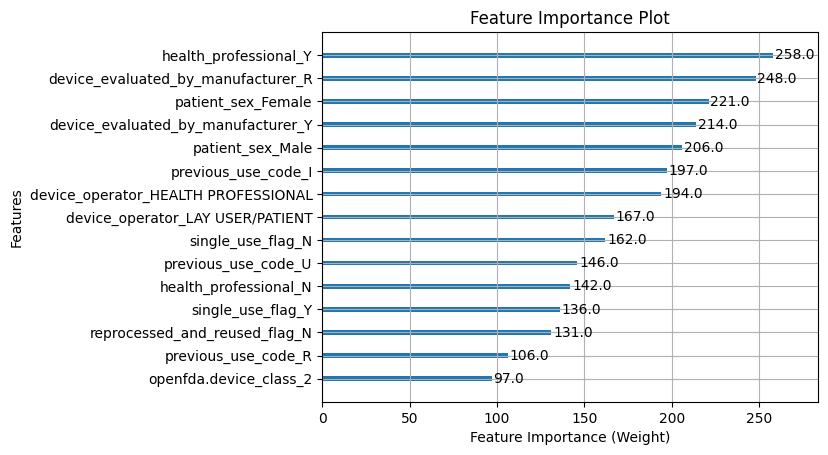

In [162]:
xgb.plot_importance(clf, importance_type='weight', max_num_features=15)  # You can adjust max_num_features

# Add labels and title
plt.xlabel('Feature Importance (Weight)')
plt.ylabel('Features')
plt.title('Feature Importance Plot')

# Show the plot
plt.show()

In [ ]:
# pip install catboost scikit-learn


In [163]:

import catboost

# Load your X and y DataFrames (replace 'X' and 'y' with your actual DataFrames)
# Example:
# X = pd.read_csv('X_data.csv')
# y = pd.read_csv('y_data.csv')

# Initialize the CatBoost classifier
clf = catboost.CatBoostClassifier()

# Fit the model on the training data
clf.fit(X_train, y_train)

# Predict on the test data
y_pred = clf.predict(X_test)

# Evaluate the model (you can use different metrics depending on your problem)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Now, 'clf' is your trained CatBoost classifier, and 'y_pred' contains the predictions on the test data


Learning rate set to 0.06693
0:	learn: 0.6112192	total: 19.4ms	remaining: 19.4s
1:	learn: 0.5467477	total: 36.2ms	remaining: 18s
2:	learn: 0.4926581	total: 71.3ms	remaining: 23.7s
3:	learn: 0.4496730	total: 88.7ms	remaining: 22.1s
4:	learn: 0.4140880	total: 109ms	remaining: 21.8s
5:	learn: 0.3861348	total: 127ms	remaining: 21s
6:	learn: 0.3621981	total: 144ms	remaining: 20.5s
7:	learn: 0.3427861	total: 162ms	remaining: 20.1s
8:	learn: 0.3272146	total: 181ms	remaining: 19.9s
9:	learn: 0.3128558	total: 198ms	remaining: 19.6s
10:	learn: 0.3019113	total: 216ms	remaining: 19.4s
11:	learn: 0.2912248	total: 233ms	remaining: 19.2s
12:	learn: 0.2832506	total: 260ms	remaining: 19.7s
13:	learn: 0.2758314	total: 278ms	remaining: 19.6s
14:	learn: 0.2697316	total: 296ms	remaining: 19.4s
15:	learn: 0.2652252	total: 314ms	remaining: 19.3s
16:	learn: 0.2605900	total: 340ms	remaining: 19.7s
17:	learn: 0.2556488	total: 358ms	remaining: 19.5s
18:	learn: 0.2532021	total: 384ms	remaining: 19.8s
19:	learn: 0

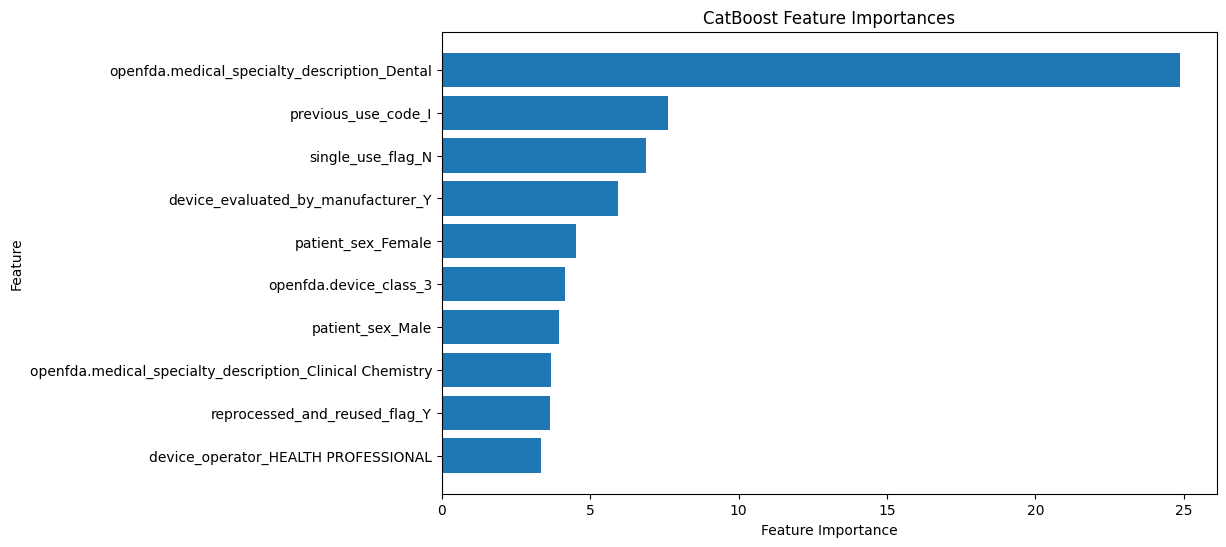

In [164]:
feature_importance = clf.get_feature_importance()
feature_names = X.columns

# Create a DataFrame to store the feature importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][:10], feature_importance_df['Importance'][:10])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('CatBoost Feature Importances')
plt.gca().invert_yaxis()  # Invert the y-axis to display the most important feature at the top
plt.show()

In [166]:

from sklearn.ensemble import RandomForestClassifier

# Load your X and y DataFrames (replace 'X' and 'y' with your actual DataFrames)
# Example:
# X = pd.read_csv('X_data.csv')
# y = pd.read_csv('y_data.csv')


# Initialize the Random Forest classifier
clf = RandomForestClassifier()

# Fit the model on the training data
clf.fit(X_train, y_train)

# Predict on the test data
y_pred = clf.predict(X_test)

# Evaluate the model (you can use different metrics depending on your problem)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Now, 'clf' is your trained Random Forest classifier, and 'y_pred' contains the predictions on the test data


Accuracy: 0.9275


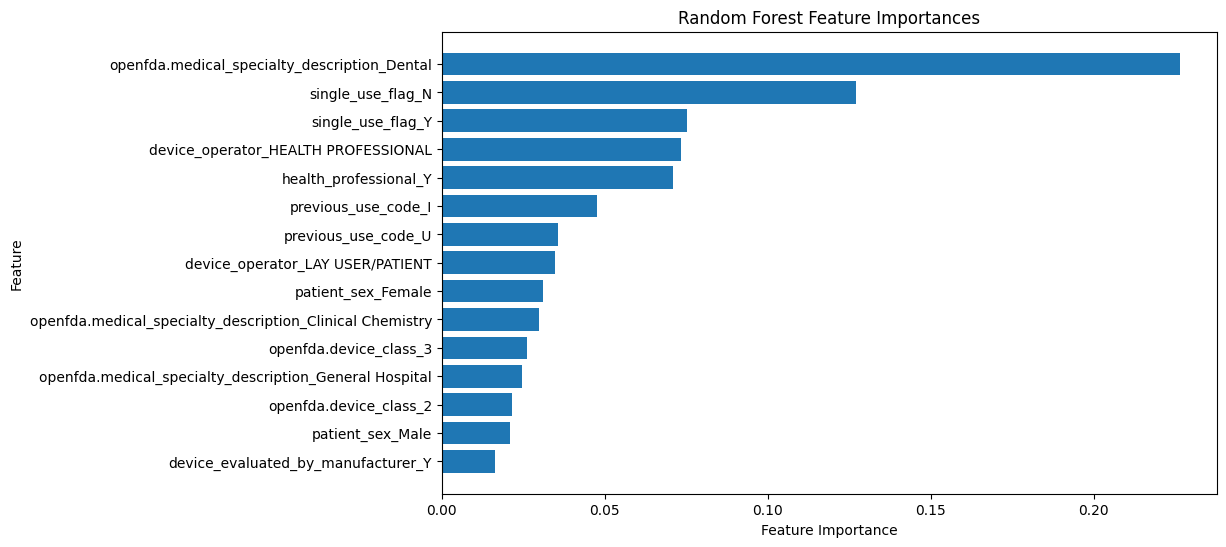

In [167]:
feature_importances = clf.feature_importances_

# Get feature names
feature_names = X.columns

# Create a DataFrame to store feature importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][:15], feature_importance_df['Importance'][:15])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importances')
plt.gca().invert_yaxis()  # Invert the y-axis to display the most important feature at the top
plt.show()